In [ ]:
!pip install simpletransformers
#SimpleTransformers is an open-source library that allows you to use the power of state-of-the-art transformer models for natural language processing tasks

# Libraries

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib.ticker import FuncFormatter

from simpletransformers.ner import NERModel,NERArgs
from gensim.models import Word2Vec

# Preprocessing for Course Data

In [72]:
data = pd.read_excel('ML_data.xlsx')
data.head()

,word,course,sentence,tag
0,master,course 0,Sentence 0,O
1,machine,course 0,Sentence 0,B-skill
2,learning,course 0,Sentence 0,I-skill
3,on,course 0,Sentence 0,O
4,python,course 0,Sentence 0,B-skill


Crating label encoded versions of the sentence column.

In [73]:
data["sentence"] = LabelEncoder().fit_transform(data["sentence"])
data.head()

,word,course,sentence,tag
0,master,course 0,0,O
1,machine,course 0,0,B-skill
2,learning,course 0,0,I-skill
3,on,course 0,0,O
4,python,course 0,0,B-skill


In [74]:
data.rename(columns={"sentence":"sentence_id","word":"words","tag":"labels"}, inplace =True)
data["labels"] = data["labels"].str.upper()
data.head()

,words,course,sentence_id,labels
0,master,course 0,0,O
1,machine,course 0,0,B-SKILL
2,learning,course 0,0,I-SKILL
3,on,course 0,0,O
4,python,course 0,0,B-SKILL


In [75]:
data.shape

(1808, 4)

## Splitting dataset
80-20 train and test data.
1446 row for train,362 row for test data

In [76]:
X = data[["sentence_id","words"]]
Y = data["labels"]

In [77]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size =0.2,random_state=42) 

In [78]:
#building up train data and test data
train_data = pd.DataFrame({"sentence_id":x_train["sentence_id"],"words":x_train["words"],"labels":y_train})
test_data = pd.DataFrame({"sentence_id":x_test["sentence_id"],"words":x_test["words"],"labels":y_test})

In [79]:
print(train_data.shape)
print(test_data.shape)


(1446, 3)
(362, 3)


In [80]:
train_data

,sentence_id,words,labels
900,3,neural,I-SKILL
1800,102,logistic,O
1128,36,a,O
964,14,algorithms,O
394,137,tableau,O
...,...,...,...
1130,36,network,I-SKILL
1294,54,hyperparameters,O
860,188,more,O
1459,66,test,O


# NER Model Training

In [81]:
label = data["labels"].unique().tolist()
label

['O', 'B-SKILL', 'I-SKILL']

## Hyperparameters for NERArgs

num_train_epochs: The number of times the model will see the entire training dataset during training.

learning_rate: The step size at which the optimizer will update the model's weights during training.

overwrite_output_dir: Whether the output directory should be overwritten if it already exists.

train_batch_size: The number of training examples processed in a single batch during training.

eval_batch_size: The number of examples processed in a single batch during evaluation.

In [82]:
args = NERArgs()
args.num_train_epochs = 8
args.learning_rate = 1e-4
args.overwrite_output_dir = True
args.train_batch_size = 32
args.eval_batch_size = 32

## BERT
- 'label' is ['O', 'B-SKILL', 'I-SKILL']

- 'bert-base-uncased', is a BERT model trained on a large dataset of lowercased English text.

- 'bert', specifies the type of model to use. In this case, the model is using the BERT (Bidirectional Encoder Representations from Transformers) architecture

- 'args' argument specifies a set of hyperparameters for training the model

In [83]:
model = NERModel('bert', 'bert-base-uncased', labels = label, args = args)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [84]:
model.train_model(train_data,eval_data = test_data,acc=accuracy_score)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 8:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/7 [00:00<?, ?it/s]

(56, 0.18996521232682945)

## Results for BERT
Overall, the evaluation results show that the model is performing well, with a low eval loss, high precision, and high F1 score. The recall is somewhat lower than the other metrics, which may indicate that the model is missing some positive examples.

In [85]:
result, model_outputs, preds_list = model.eval_model(test_data)
result

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.2285147277638316,
 'precision': 0.868421052631579,
 'recall': 0.717391304347826,
 'f1_score': 0.7857142857142858}

In [86]:
prediction, model_output = model.predict(["master machine learning on python"])
prediction

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

[[{'master': 'O'},
  {'machine': 'B-SKILL'},
  {'learning': 'I-SKILL'},
  {'on': 'O'},
  {'python': 'B-SKILL'}]]

# Most frequent ML engineer skills for calculate similarity


In [106]:
ML_skills = []

In [88]:
df_skill = pd.read_csv("ML_skills.csv", header=None, sep=";")
df_skill["skills"] = [row.split("{")[2] for row in df_skill[0]]
df_skill= df_skill.drop(columns=0,axis=1)
df_skill.head()
df_skill['skills'] = df_skill['skills'].apply(lambda x: x.split(", 'skill'")[1])
def clean(text):
    cleaned_text = text[2:-3]
    a = cleaned_text.split(", ")
    a = [i[1:-1] for i in a]
    return a

df_skill["skills"] = df_skill["skills"].apply(clean)
f = lambda x: ','.join(map(str, x)) if isinstance(x, list) else x
df_skill['skills'] = df_skill['skills'].apply(f)
df_skill['skills'] = df_skill['skills'].apply(lambda x: x.replace("'", ''))
df_skill['skills'] = df_skill['skills'].str.lower()

In [89]:
def remove_duplicate_words(string):
  words = string.split(",")
  unique_words = []

  # iterate through the list of words
  for word in words:
    # if the word is not in the list of unique words, append it
    if word not in unique_words:
      unique_words.append(word)

  # join the list of unique words into a string and return it
  return ", ".join(unique_words)

df_skill["skills"] = df_skill["skills"].apply(remove_duplicate_words)

In [90]:
df_skill['words'] = df_skill['skills'].apply(lambda x: x.split(","))
word_freq = {}
for row in df_skill['words']:
    for word in row:
        if word not in word_freq:
            word_freq[word] = 1
        else:
            word_freq[word] += 1

In [107]:
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
top_15_words = sorted_word_freq[:15]
for word, freq in top_15_words:
    ML_skills.append(word)
    print(f'{word}: {freq}')

 python: 63
 java: 60
 c++: 59
 machine learning: 56
 sql: 51
 c: 44
 deep learning: 41
 matlab: 40
 data analysis: 35
 r: 34
 tensorflow: 32
 algorithms: 31
 data mining: 30
 linux: 29
 mysql: 27


In [92]:
ML_skills

[' python',
 ' java',
 ' c++',
 ' machine learning',
 ' sql',
 ' c',
 ' deep learning',
 ' matlab',
 ' data analysis',
 ' r',
 ' tensorflow',
 ' algorithms',
 ' data mining',
 ' linux',
 ' mysql']

In [112]:
separated_skills = []
for skill in ML_skills:
  words = skill.split(' ')  # Split the skill on the space character
  separated_skills.extend(words)  # Add the words to the separated_skills list
separated_skills = [skill for skill in separated_skills if skill != '']
print(separated_skills)

['python', 'java', 'c++', 'machine', 'learning', 'sql', 'c', 'deep', 'learning', 'matlab', 'data', 'analysis', 'r', 'tensorflow', 'algorithms', 'data', 'mining', 'linux', 'mysql']


# Reading the ML course phrases

In [93]:
ML_phrases = pd.read_excel('ML_phrases.xlsx')
ML_phrases

,text,course
0,master machine learning on python r,course 0
1,have a great intuition of many machine learnin...,course 0
2,make accurate predictions,course 0
3,make powerful analysis,course 0
4,make robust machine learning models,course 0
...,...,...
189,multiple linear regression,course 14
190,logistic regression,course 14
191,cluster analysis,course 14
192,kmeans clustering,course 14


## Creating dict includes only skill entities for each courses
Skill entites found earlier by NER

In [ ]:
course_dict = {}
for row in ML_phrases.iterrows():
  row = row[1]
  text = row['text']
  words = text.split()
  course = row['course']
  if course not in course_dict:
    course_dict[course] = []
  entities, _ = model.predict([text])
  lst = []
  for i, word in enumerate(words):
    if(entities[0][i][word]!= 'O'):
      lst.append(word)
  course_dict[course].extend(lst)

In [ ]:
#course_dict

# Word2Vec Model
Loading the word2vec course outcome model. 
  More info. at: 
  
  AIN311_Project/tree/main/word2vec_model

In [102]:
model = Word2Vec.load("course.model")

In [131]:
# Find the most similar courses related to most common ML skills
similarities = {}
for course in course_dict:
  entities = course_dict[course]
  sum = 0
  length = 0
  for word in entities:
    for skill in separated_skills:
      try:
        sum+=model.wv.similarity(w1 = word, w2= skill)
        length+=1
      except:
        #print(word, skill)
        continue
  sum/=length #average

  similarities[course] = sum

# RESULT
You can check each course below.

In [115]:
similarities

{'course 0': 0.8057417311150619,
 'course 1': 0.7306398546436068,
 'course 2': 0.7838463827367287,
 'course 3': 0.7474901828741419,
 'course 4': 0.8415513505989854,
 'course 5': 0.7040747634986824,
 'course 6': 0.5928754869647409,
 'course 7': 0.5259374268917423,
 'course 8': 0.7631879303265702,
 'course 9': 0.8040103361462102,
 'course 10': 0.7753377349087687,
 'course 11': 0.7165623781355944,
 'course 12': 0.7454090995636268,
 'course 13': 0.8243101943622936,
 'course 14': 0.6727199862142662}

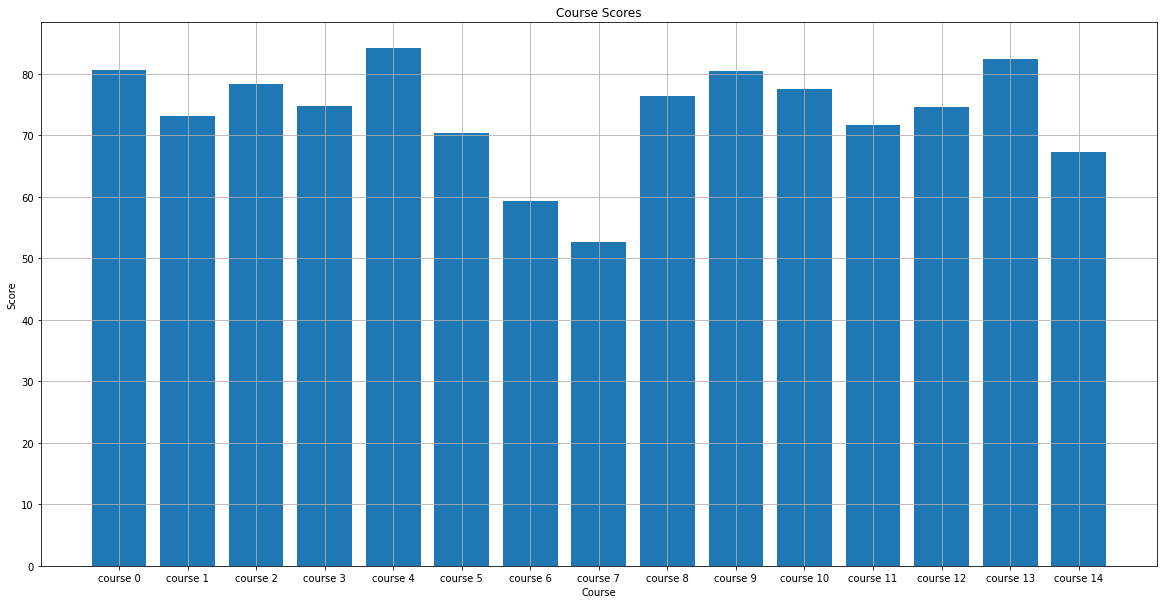

In [129]:

def y_format(y, pos):
    return '{:,.0f}'.format(y * 100)
fig = plt.figure(figsize=(20, 10))

course_names = list(similarities.keys())
scores = list(similarities.values())

plt.bar(course_names, scores)
plt.xlabel('Course')
plt.ylabel('Score')
plt.title('Course Scores')
formatter = FuncFormatter(y_format)
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid()
plt.show()

- Course 0: https://www.udemy.com/course/machinelearning/

- Course 1: https://www.udemy.com/course/python-for-data-science-and-machine-learning-bootcamp/

- Course 2: https://www.udemy.com/course/python-for-machine-learning-data-science-masterclass/

- Course 3: https://www.udemy.com/course/the-data-science-course-complete-data-science-bootcamp/

- Course 4: https://www.udemy.com/course/feature-engineering-for-machine-learning/

- Course 5: https://www.udemy.com/course/data-science-and-machine-learning-with-python-hands-on/

- Course 6: https://www.udemy.com/course/natural-language-processing-in-python/

- Course 7: https://www.udemy.com/course/deeplearning/

- Course 8: https://www.udemy.com/course/aws-machine-learning/

- Course 9: https://www.udemy.com/course/statsml_x/

- Course 10: https://www.udemy.com/course/data-science-deep-learning-in-python/

- Course 11: https://www.udemy.com/course/machine-learning-with-javascript/

- Course 12: https://www.udemy.com/course/become-an-aws-machine-learning-engineer-in-30-days-new-2022/

- Course 13: https://www.udemy.com/course/data-science-and-machine-learning-bootcamp-with-r/

- Course 14: https://www.udemy.com/course/excel-for-data-science-and-machine-learning/